In [1]:
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statistics
import os
import sys
from tqdm import tqdm
from scipy import stats
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def read_gene_expression_data(path):
    data_frame_0 = pd.DataFrame()
    data_frame_1 = pd.DataFrame()

    for file_name in tqdm(os.listdir(path), desc=">> Reading patient data...", file=sys.stdout):
        file_path = os.path.join(path, file_name)
        with open(file_path) as f:
            patient_df = pd.read_csv(f, sep="\t", header=None, index_col=0, names=[file_name.replace(".txt", "")])
            patient_df = pd.DataFrame.transpose(patient_df)
            if file_name.endswith("_0.txt"):
                data_frame_0 = data_frame_0.append(patient_df)
            else:
                data_frame_1 = data_frame_1.append(patient_df)
    return data_frame_0, data_frame_1


def remove_genes_with_median_0(data_frame):
    """
    Description: Removes the genes for which the median calculated
                 on all patients (healthy + sick) is = 0
    :param data_frame:
    :return data_frame:
    :return removed_genes:
    """
    removed_genes = []
    for gene in tqdm(data_frame.columns, desc=">> Compute median for each gene...", file=sys.stdout):
        median = statistics.median(data_frame[gene])
        if median == 0:
            removed_genes.append(gene)

    data_frame = data_frame.drop(columns=removed_genes)
    return data_frame, removed_genes


def anderson_normality_test(data_frame_0, data_frame_1):
    """
    Description: Anderson test
    :param data_frame_0:
    :param data_frame_1:
    :return:
    """
    normal_genes = []
    for gene in tqdm(data_frame_0.columns, desc="Checking normality for each gene...", file=sys.stdout):
        statistic_0, pvalue_0, alpha_0 = stats.anderson(data_frame_0[gene])
        pvalue_0_max = max(pvalue_0)

        statistic_1, pvalue_1, alpha_1 = stats.anderson(data_frame_1[gene])
        pvalue_1_max = max(pvalue_1)

        if statistic_0 < pvalue_0_max and statistic_1 < pvalue_1_max:
            normal_genes.append(gene)

    return normal_genes


def shapiro_normality_test(data_frame_0, data_frame_1, alpha):
    """
    Description: Shapiro test
    :param alpha:
    :param data_frame_0:
    :param data_frame_1:
    :return:
    """
    normal_genes = []
    for gene in tqdm(data_frame_0.columns, desc="Checking normality for each gene...", file=sys.stdout):
        statistic_0, pvalue_0 = stats.shapiro(data_frame_0[gene])
        statistic_1, pvalue_1 = stats.shapiro(data_frame_1[gene])

        if pvalue_0 > alpha and pvalue_1 > alpha:
            normal_genes.append(gene)

    return normal_genes


def normal_test(data_frame_0, data_frame_1, alpha):
    """
    Description: Normal test
    :param alpha:
    :param data_frame_0:
    :param data_frame_1:
    :return:
    """
    normal_genes = []
    for gene in tqdm(data_frame_0.columns, desc="Checking normality for each gene...", file=sys.stdout):
        statistic_0, pvalue_0 = stats.normaltest(data_frame_0[gene])
        statistic_1, pvalue_1 = stats.normaltest(data_frame_1[gene])

        if pvalue_0 > alpha and pvalue_1 > alpha:
            normal_genes.append(gene)

    return normal_genes


def mann_whitney_u_test(data_frame_0, data_frame_1, alpha):
    """
    Description: Non-parametric statistical test
    :param data_frame_0:
    :param data_frame_1:
    :param alpha:
    :return m_reduced_genes:
    """
    m_reduced_genes = []

    for gene in tqdm(data_frame_0.columns, desc=">> Computing test for each gene...", file=sys.stdout):
        statistic, pvalue = stats.mannwhitneyu(data_frame_0[gene].tolist(), data_frame_1[gene].tolist())
        if pvalue < alpha / len(data_frame_0.columns):  # Bonferroni adjustment
            m_reduced_genes.append(gene)

    return m_reduced_genes


def welch_t_test(data_frame_0, data_frame_1, alpha):
    """
    Description: Parametric statistical test
    :param data_frame_0:
    :param data_frame_1:
    :param alpha:
    :return:
    """
    w_reduced_genes = []

    for gene in tqdm(data_frame_0.columns, desc=">> Computing test for each gene...", file=sys.stdout):
        tvalue, pvalue = stats.ttest_ind(np.array(data_frame_0[gene].tolist()),
                                         np.array(data_frame_1[gene].tolist()),
                                         equal_var=False, nan_policy='omit')
        if not np.isnan(pvalue) and pvalue <= alpha / len(data_frame_0.columns):
            w_reduced_genes.append(gene)

    return w_reduced_genes


def plot_histograms(df_0, df_1, colors):
    """
    Function: Per-class feature histograms, for the genes discarded by statistical test
    Description: Create histograms, one for each feature, each one counting how many patients appear
                      with a feature (gene expression value) in a certain range (called bin).
                      Each plot contains 2 histograms one for the healthy patients and
                      the other for the diseased patients.
    :param colors:
    :param df_1:
    :param df_0:
    :return:
    """
    df = df_0.append(df_1)
    fig, axes = plt.subplots(15, 2, figsize=(10, 20))
    ax = axes.ravel()
    for i, gene in enumerate(df.columns):
        _, bins = np.histogram(df[gene], bins=50)
        ax[i].hist(df_1[gene], bins=bins, color=colors[0], alpha=.5)
        ax[i].hist(df_0[gene], bins=bins, color=colors[1], alpha=.9)
        ax[i].set_title(gene)
        ax[i].set_yticks(())
        if i == 29:
            break
    ax[0].set_xlabel("Feature magnitude")
    ax[0].set_ylabel("Frequency")
    ax[0].legend(["malignant", "benign"], loc="best")
    fig.tight_layout()
    plt.show()


def plot_variance_vs_num_components(x):
    """
    Description : The curve quantifies how much of the total, 13595-dimensional variance
                  is contained within the first N components
    :param x:
    :return:
    """
    pca = PCA()
    pca.fit(x)
    cumsum = np.cumsum(pca.explained_variance_ratio_)  # Cumulative proportion of variance (from first PC to last PC)
    d = np.argmax(cumsum >= 0.95) + 1  # num of components required to preserve 95% of training set variance
    plt.plot(cumsum)
    plt.vlines(d, 0, cumsum[d], linestyles='dashed', linewidths=0.5)
    plt.hlines(cumsum[d], 0, d, linestyles='dashed', linewidths=0.5)
    plt.scatter(d, cumsum[d], facecolors='black', alpha=.9, s=25)
    plt.annotate('Elbow', xytext=(130, 0.65), xy=(100, 0.8), arrowprops={'facecolor': 'black'})
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)
    plt.xlabel("Number of components")
    plt.ylabel("Cumulative explained variance")
    plt.show()

def plot_hierarchical_clustering(df):
    """
    Description: Plot hierarchical clustering dendrogram and heatmap.
    :param df:
    :return:
    """
    #heatmap_data = pd.pivot_table(df, values=df.index, index=df.index, columns=df.columns)
    hcplot = sns.clustermap(df)
    plt.show()

def random_undersample(df, size):
    random_indices = np.random.choice(df.index, size, replace=False)
    df_undersampled = df.loc[random_indices]
    return random_indices, df_undersampled

def scree_plot(pca):
    plt.plot(pca.explained_variance_)
    plt.xlabel('Principal component')
    plt.ylabel('Eigenvalue')
    plt.show()

def biplot(score, coeff, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    plt.show()

def plot_pca_2D(X_train_pca, y_train):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = ['0', '1']
    colors = ['r', 'g']
    for target, color in zip(targets,colors):
        indices_to_keep = np.array(y_train == target)
        ax.scatter(X_train_pca[indices_to_keep, 1] # first principal component
                   , X_train_pca[indices_to_keep, 2] # second principal component
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()
    plt.show()

In [3]:
#################################################
#   1 - Reading data and exploratory analysis   #
#################################################

path_ge = "..\\assets\\final_genes\\"

# 1.a Reading data
print("Reading gene expression data:")
df_0, df_1 = read_gene_expression_data(path_ge)

# 1.b Exploratory analysis
print("\nExploratory analysis:")

# 1.b.2 Compute number of samples
n_samples_0 = len(df_0)
n_samples_1 = len(df_1)
print(f'>> Tumor samples: {n_samples_1}'
      f'\n>> Normal samples: {n_samples_0}')

# 1.b.1 Compute number of features
df = df_0.append(df_1, sort=False)  # Merge healthy data frame with diseased data frame
n_features = len(df.columns)
print(f">> Number of features (genes): {n_features}")



Reading gene expression data:
>> Reading patient data...: 100%|██████████| 500/500 [01:03<00:00,  7.84it/s]

Exploratory analysis:
>> Tumor samples: 458
>> Normal samples: 42
>> Number of features (genes): 60483



Differentially gene expression analysis [DGEA]
[DGEA pre-processing] Removing genes with median = 0:
>> Compute median for each gene...: 100%|█| 60483/60483 [00:17<00:00, 3407.50it
>> Removed genes: ['ENSG00000242268.2', 'ENSG00000270112.3', 'ENSG00000273842.1', 'ENSG00000225275.4', 'ENSG00000231981.3', 'ENSG00000269475.2', 'ENSG00000201788.1', 'ENSG00000234943.2', 'ENSG00000271616.1', 'ENSG00000234881.1', 'ENSG00000236040.1', 'ENSG00000243044.1', 'ENSG00000264981.1', 'ENSG00000275265.1', 'ENSG00000233540.1', 'ENSG00000271647.1', 'ENSG00000262950.1', 'ENSG00000255420.1', 'ENSG00000280038.1', 'ENSG00000274458.1', 'ENSG00000273406.1', 'ENSG00000278099.1', 'ENSG00000166368.2', 'ENSG00000206072.11', 'ENSG00000220993.1', 'ENSG00000214062.5', 'ENSG00000274219.1', 'ENSG00000230100.1', 'ENSG00000254465.1', 'ENSG00000166634.5', 'ENSG00000261789.1', 'ENSG00000254092.1', 'ENSG00000197421.8', 'ENSG00000260900.1', 'ENSG00000278732.1', 'ENSG00000268465.1', 'ENSG00000264438.2', 'ENSG00000204113.6', 

>> First 10 values before transformation:
                                        ENSG00000167578.15  ENSG00000078237.5  \
07dc5a1d-64b7-42ba-928e-9753bd533c1e_0        64786.780348       86937.767935   
0f74d992-00da-4728-9564-086ca1b95921_0       132103.017466      106852.165279   
19d1a5fc-3ce9-4e43-a364-a4150bcf911b_0       105532.428638       95640.535532   
269e8ca8-722d-449b-ace1-6545bd72bdd6_0       100957.163940      109348.520894   
28d03569-8717-40da-8989-70baf2b18f9f_0       138662.885139       77034.969345   
2b94070a-21ec-457b-88af-3d2a89b97ac6_0       132378.114919       76029.485131   
31a3877d-3e82-450e-811f-3448b06f3950_0       126269.985943       92858.394062   
3a785e32-7960-4c72-84c4-fb42c4dd86f1_0        87539.831662       59640.872688   
401a37f3-6630-4400-a811-a262351e37de_0       192177.638230      110193.529733   
49929108-023e-4d35-b26d-50ab4d3ae581_0       160255.708442       79491.142619   

                                        ENSG00000146083.10  \
07dc

[DGEA statistical test] Welch t-test statistics:
>> Computing test for each gene...: 100%|█| 28547/28547 [00:36<00:00, 786.54it/
>> Reduced genes: ['ENSG00000167578.15', 'ENSG00000078237.5', 'ENSG00000146083.10', 'ENSG00000198242.12', 'ENSG00000259883.1', 'ENSG00000134108.11', 'ENSG00000263089.1', 'ENSG00000172137.17', 'ENSG00000167700.7', 'ENSG00000060642.9', 'ENSG00000231105.1', 'ENSG00000269416.4', 'ENSG00000185105.4', 'ENSG00000166391.13', 'ENSG00000070087.12', 'ENSG00000153561.11', 'ENSG00000179262.8', 'ENSG00000234900.1', 'ENSG00000258630.1', 'ENSG00000127511.8', 'ENSG00000225269.2', 'ENSG00000064601.15', 'ENSG00000215246.5', 'ENSG00000276644.3', 'ENSG00000196167.8', 'ENSG00000179833.4', 'ENSG00000064225.11', 'ENSG00000057294.12', 'ENSG00000167768.4', 'ENSG00000218358.2', 'ENSG00000120662.14', 'ENSG00000235523.1', 'ENSG00000164283.11', 'ENSG00000258279.2', 'ENSG00000204581.2', 'ENSG00000184178.14', 'ENSG00000166913.11', 'ENSG00000164112.11', 'ENSG00000130204.11', 'ENSG00000111863

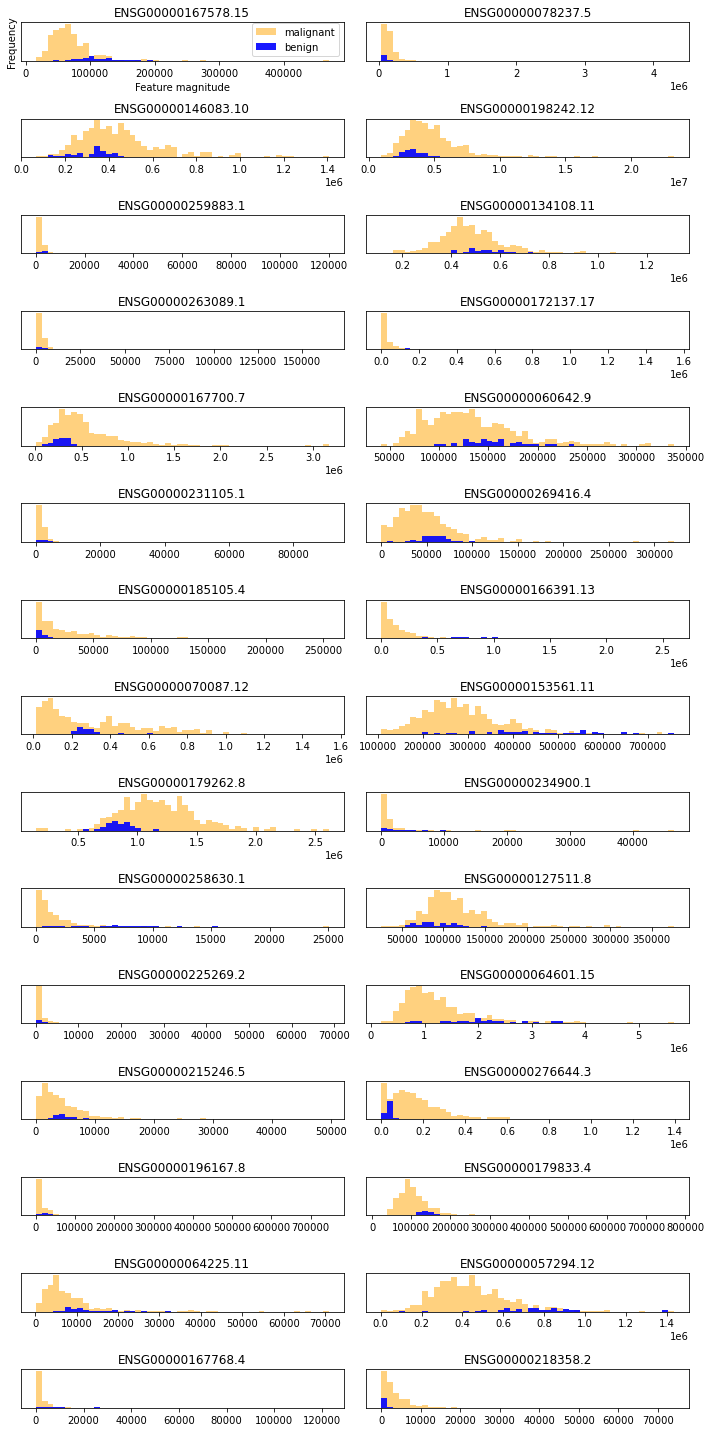


[DGEA visualization step] Per-class feature histograms, for first 30 genes discarded by Welch t test


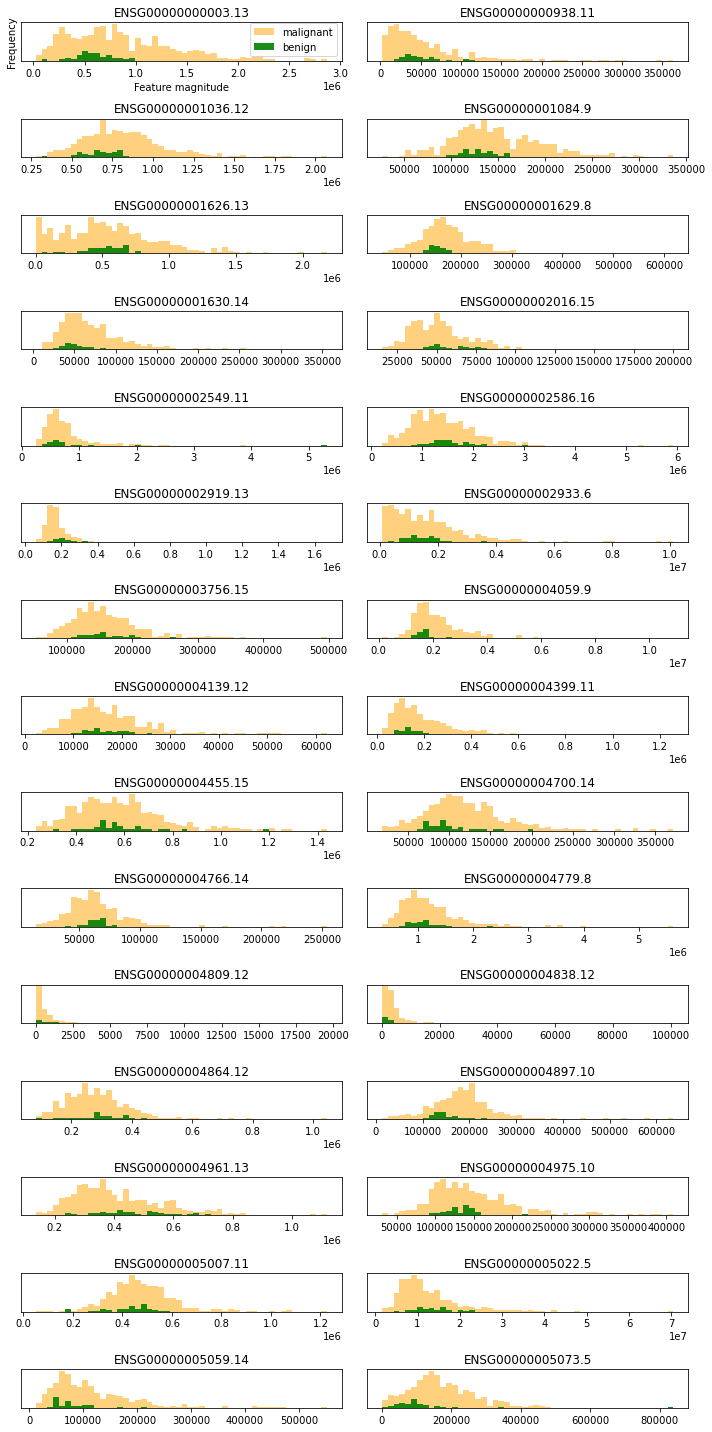

In [6]:
###################################################
#   2 - Differentially gene expression analysis   #
###################################################

# 2.a Pre-processing data
print("\nDifferentially gene expression analysis [DGEA]")


# 2.a.1 Remove genes with median = 0
print("[DGEA pre-processing] Removing genes with median = 0:")
df, removed_genes = remove_genes_with_median_0(df)
n_features = len(df.columns)  # update number of features

print(f'>> Removed genes: {removed_genes}'
      f'\n>> Number of genes removed: {len(removed_genes)}'
      f'\n>> Number of genes remained: {n_features}')

# 2.a.2 Apply logarithmic transformation on gene expression data
#       Description : x = Log(x+1), where x is the gene expression value
print(f'\n[DGEA pre-processing] Logarithmic transformation on gene expression data:'
      f'\n>> Computing logarithmic transformation...')
df_log_transformed = df.applymap(lambda x: math.log(x + 1, 10))

print(f'>> First 10 values before transformation:\n{df.head(10)}')
print(f'>> First 10 values after transformation:\n{df_log_transformed.head(10)}')

# Separate patients data frame in normal data frame and tumor data frame
df_0_log_transformed = df_log_transformed.loc[df_log_transformed.index.str.endswith('_0')]
df_1_log_transformed = df_log_transformed.loc[df_log_transformed.index.str.endswith('_1')]

'''
# 2.a.3 Check for normality of our data
#       For each gene, I check the normality distribution
#       of the 2 groups of data (healthy data and diseased data)
alpha = 0.05
# Anderson test
print("\n[DGEA pre-processing] Anderson test:")
a_normal_genes = anderson_normality_test(df_log_transformed, df_1_log_transformed)

# Shapiro test
print("\n[DGEA pre-processing] Shapiro test:")
s_normal_genes = shapiro_normality_test(df_0_log_transformed, df_1_log_transformed, alpha)

# Normal test
print("\n[DGEA pre-processing] Normal test:")
n_normal_genes = normal_test(df_0_log_transformed, df_1_log_transformed, alpha)

# Results
print(f'\n>> Number of genes with both healthy and diseased patient groups normally distributed:'
      f'\n>> Result for Anderson test: {len(a_normal_genes)} (over {n_features})'
      f'\n>> Result for Shapiro test: {len(s_normal_genes)} (over {n_features})'
      f'\n>> Result for Normal test: {len(n_normal_genes)} (over {n_features})')
'''

# 2.b Statistical test
'''
# 2.b.1 Mann–Whitney U test
alpha = 0.05
print("\n[DGEA statistical test] Mann–Whitney U test statistics:")
m_reduced_genes = mann_whitney_u_test(df_0, df_1, alpha)

print(f'>> Reduced genes: {m_reduced_genes}'
      f'\n>> Number of selected genes (features): {len(m_reduced_genes)}')
'''

# 2.b.2 Welch t test
print("\n[DGEA statistical test] Welch t-test statistics:")
alpha = 0.05
w_reduced_genes = welch_t_test(df_0_log_transformed, df_1_log_transformed, alpha)

df_reduced = df[w_reduced_genes]
n_features = len(df_reduced.columns)  # update number of features

df_reduced_0 = df_reduced.loc[df_reduced.index.str.endswith('_0')]
df_reduced_1 = df_reduced.loc[df_reduced.index.str.endswith('_1')]

print(f'>> Reduced genes: {w_reduced_genes}'
      f'\n>> Number of selected genes (features): {n_features}'
      f'\n>> Shape of reduced normal dataset: {df_reduced_0.shape}'
      f'\n>> Shape of reduced tumor dataset: {df_reduced_1.shape}')

# 2.d Per-class feature histograms, for the genes selected by Welch t test
print("\n[DGEA visualization step] Per-class feature histograms, for first 30 genes selected by Welch t test")
plot_histograms(df_reduced_0, df_reduced_1, colors=['orange', 'blue'])

# 2.c Per-class feature histograms, for the genes discarded by Welch t test
print("\n[DGEA visualization step] Per-class feature histograms, for first 30 genes discarded by Welch t test")
w_not_selected_genes = df.columns.difference(w_reduced_genes)
df_no_expr = df[w_not_selected_genes]
plot_histograms(df_no_expr.loc[df_no_expr.index.str.endswith('_0')],
                df_no_expr.loc[df_no_expr.index.str.endswith('_1')], colors=['orange', 'green'])




C:\Users\rosee\miniconda3\lib\site-packages\seaborn\matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


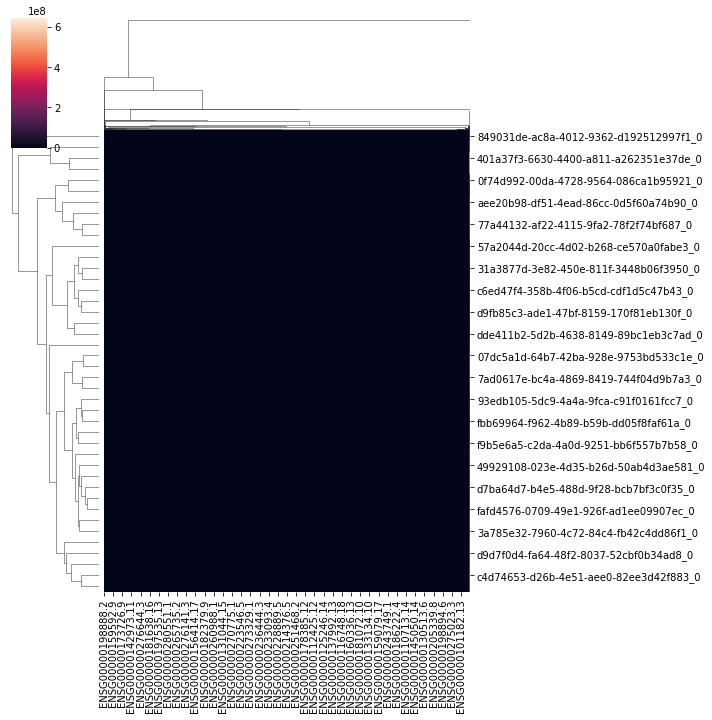

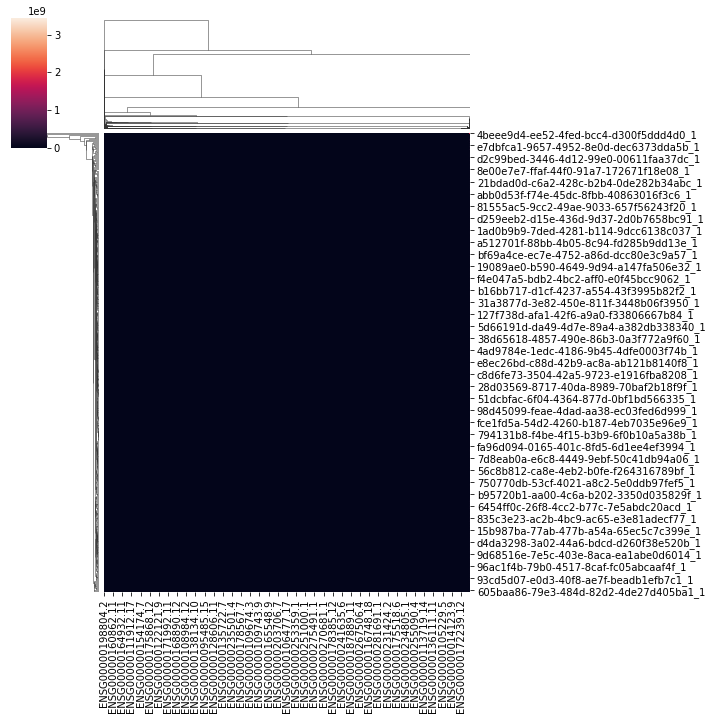

In [5]:
# 2.d hierarchical clustering
# TODO
plot_hierarchical_clustering(df_reduced_0)
plot_hierarchical_clustering(df_reduced_1)


[DGEA dimensionality reduction] Principal component analysis (PCA)
>> Shape of training set after PCA: (121, 88)
>> Shape of validation set after PCA: (24, 88)
>> Shape of test set after PCA: (97, 88)
>> Plotting the explained variance as a function of the number of dimensions


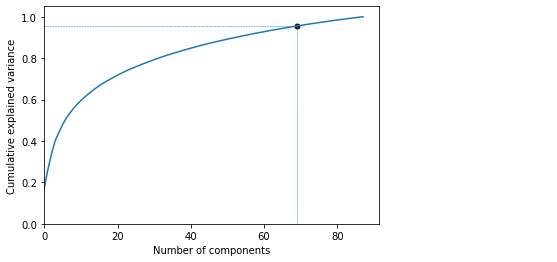

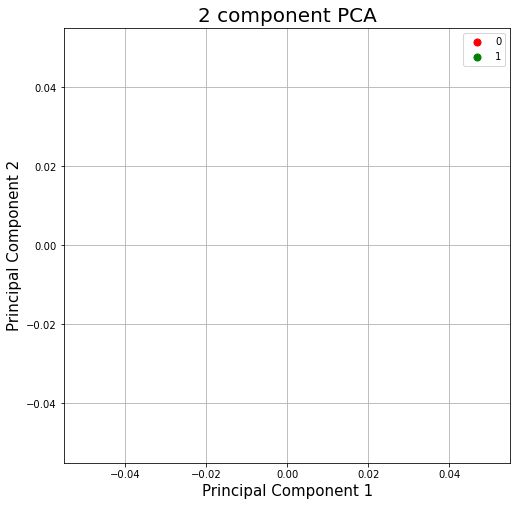

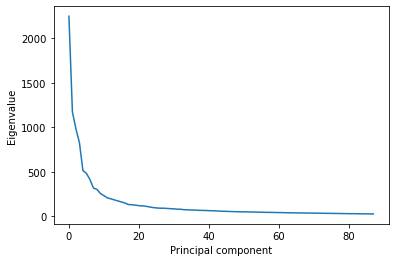

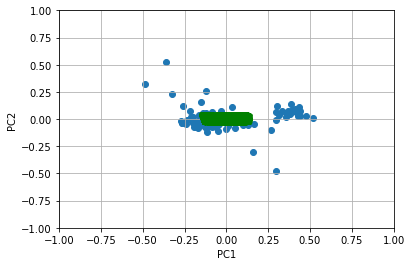

In [7]:
# 2.e PCA
print("\n[DGEA dimensionality reduction] Principal component analysis (PCA)")
# 2.e.1 Undersample majority class and divide data in training and test data

sample_size = 200
indices_undersampling, X_train_1 = random_undersample(df_reduced_1, sample_size)
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(X_train_1, X_train_1.index,
                                                                                  train_size=0.50, random_state=0)
X_valid_1, X_test_1, y_valid_1, y_test_1 = train_test_split(X_valid_1, y_valid_1,
                                                                                  train_size=0.20, random_state=0)
X_train_0, X_valid_0, y_train_0, y_valid_0 = train_test_split(df_reduced_0, df_reduced_0.index,
                                                                                  train_size=0.50, random_state=0)
X_valid_0, X_test_0, y_valid_0, y_test_0 = train_test_split(X_valid_0, y_valid_0,
                                                                                  train_size=0.20, random_state=0)

X_train = X_train_1.append(X_train_0)
X_valid = X_valid_1.append(X_valid_0)
X_test = X_test_1.append(X_test_0)
y_train = y_train_1.append(y_train_0)
y_valid = y_valid_1.append(y_valid_0)
y_test = y_test_1.append(y_test_0)

# Save case_ids in separate arrays:
cid_train = [x[:-2] for x in y_train]
y_train = [x[-1:] for x in y_train]
cid_valid = [x[:-2] for x in y_valid]
y_valid = [x[-1:] for x in y_valid]
cid_test = [x[:-2] for x in y_test]
y_test = [x[-1:] for x in y_test]

# 2.e.2 Standardize features by removing the mean and scaling to unit variance
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)
X_test = sc.transform(X_test)

# 2.e.3 Perform the dimensionality reduction onto dataset with PCA (principal component Analysis)
#       Description : n_components = 0.95 indicates that the amount of variance that needs
#                     to be explained is greater than the percentage specified by n_components
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)
print(f'>> Shape of training set after PCA: {X_train_pca.shape}')
print(f'>> Shape of validation set after PCA: {X_valid_pca.shape}')
print(f'>> Shape of test set after PCA: {X_test_pca.shape}')

# 2.e.4 Plot the explained variance as a function of the number of dimensions
print(f'>> Plotting the explained variance as a function of the number of dimensions')
plot_variance_vs_num_components(X_train_pca)

# Plot first vs second principal component
plot_pca_2D(X_train_pca, y_train)

# Scree plot
scree_plot(pca)

# Biplot
#biplot(X_train_pca[:, 0:2], np.transpose(pca.components_[0:2, :]))

In [11]:
indices_to_keep = np.array(y_train == '1')
print(np.array(y_train == '1'))
print(X_train_pca[indices_to_keep, 1])

False
[]


In [ ]:
print('ciao')